# Detecting Alzheimer's in Elderly Patients budget ass code üíÄ

In [28]:
#importing relevant libraries, add more if needed
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

In [29]:
#reading the dataset
path = Path("oasis_longitudinal_demographics_data.csv")
df = pd.read_csv(path)
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'oasis_longitudinal_demographics_data.csv'

# Data Exploration
*Exploring the entire dataset before preprocessing*

Data variables:
- `Subject ID`: ID of the subject
- `MRI ID`: ID used for the MRI image (not using since we cant get that to work because god hates me)
- `Group`: If the person had alzheimers **CLASSIFICATION VARIABLE**
- `Visit`: The visit number of the patient 
- `MR Delay`: something idk man
- `M/F`: gender
- `Hand`: hand dominance **(not using cause the distribution is too biased)**
- `Age`: age
- `EDUC`: education levels
- `SES`: socieconomic status
- `MMSE`: mini mental state examination
- `CDR`: clinical dementia rating
- `eTIV`: estimated total intracranial volume
- `nWBV`: normalize whole brain volume
- `ASF`: atlas scaling factor

In [ ]:
#hand values are all right handed so we are not using that
df.Hand.value_counts()

Hand
R    373
Name: count, dtype: int64


NOTE: When analysing, ig use `df_copy` instead of `df` since i replaced *Converted* with *Demented* to allow binary classification

* Demented is group 0
* Nondemented is group 1
---






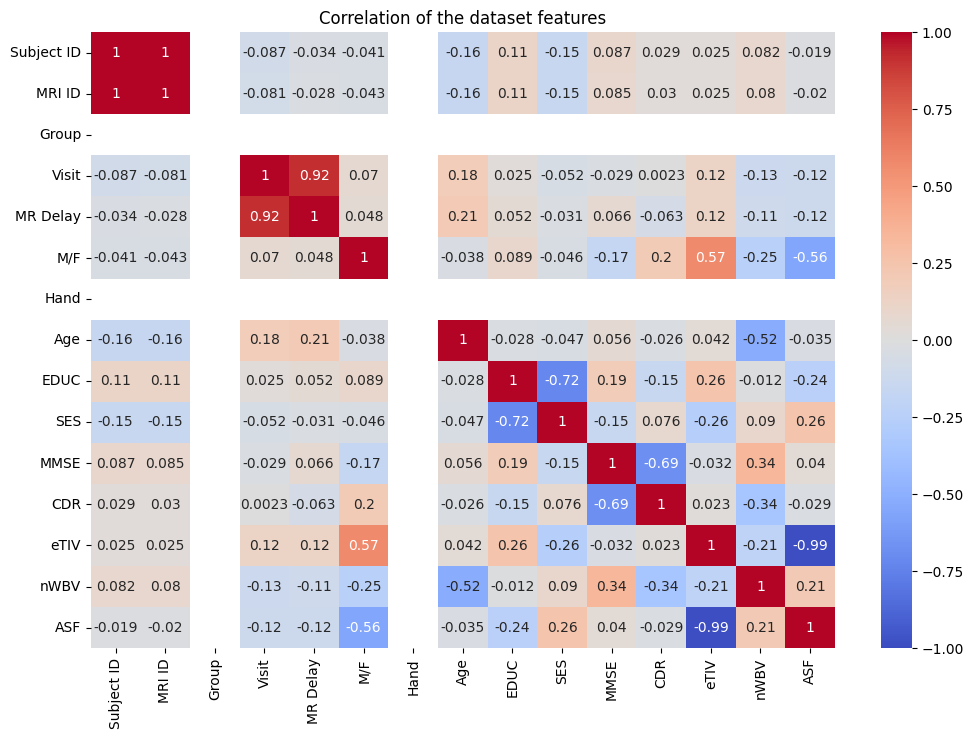

In [23]:
#preparing the correlation matrix for the dataset
encoder = LabelEncoder()

#replacing the "Converted" value into "Demented" to allow binary classification
df_copy = df.copy()
df_copy['Group'] = df_copy['Group'].replace({'Converted': 'Demented'})
# print(df_copy['Group'].value_counts())
df_copy['Group'] = encoder.fit_transform(df_copy['Group'])
# display(df_copy)


#creating the correlation
df_corr = df_copy.select_dtypes(include=['float64', 'int64'])
corr_matrix = df_corr.corr()

#displaying the correlation
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation of the dataset features')
plt.show()

From the correlation matrix, we discovered that the `MMSE` and `nWBV` variables maintains a positive correlation to the class variable, highlighting their impact towards the classification

In [ ]:
print(encoder.classes_)

['Demented' 'Nondemented']


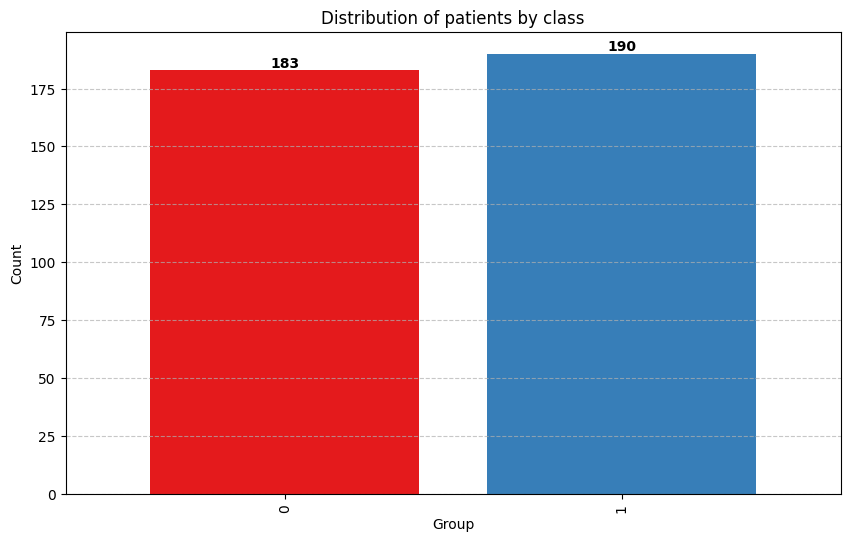

In [ ]:
classes = df_copy.Group.value_counts(ascending=True)

ax = classes.plot(kind='bar', figsize=(10, 6), color=plt.cm.Set1.colors, width=0.8)

for p in ax.patches:
  ax.annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xlabel("Group")
plt.ylabel("Count")
plt.title("Distribution of patients by class")
plt.grid(axis='y', linestyle='--', alpha=0.7)

The class distribution is fairly balanced so idk if we need to balance it more or not using SMOTE.

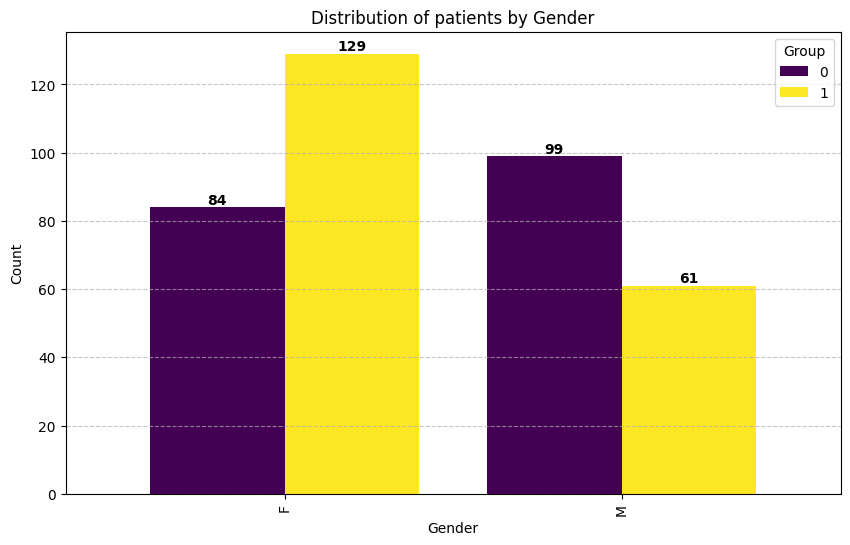

In [ ]:
#bar chart of the gender based on group
#NOTE: we're gonna have to merge "Converted" with "Demented" when classifying, i started doing it in the preprocessing section.
#ps, i merged them here on a COPY of the dataset.
gender_counts = df_copy.groupby(['M/F', 'Group']).size().unstack()

ax = gender_counts.plot(kind='bar', figsize=(10, 6), colormap='viridis', width=0.8)

for p in ax.patches:
  ax.annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xlabel("Gender")
plt.ylabel("Count")
plt.title("Distribution of patients by Gender")
plt.legend(title="Group")
plt.grid(axis='y', linestyle='--', alpha=0.7)

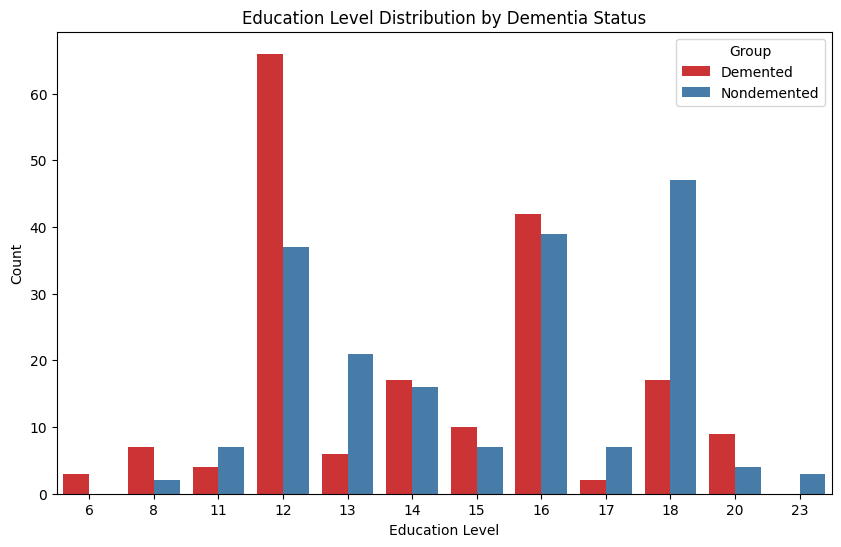

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_copy, x='EDUC', hue='Group', palette='Set1')
plt.title('Education Level Distribution by Dementia Status')
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.legend(title='Group', labels = ["Demented", "Nondemented"])
plt.show()

* Large majority of Demented individuals recieved level 12 education
* At level 20, Nondemened count is slightly higher, could suggest higher education does not directly correlate to protection against Dementia



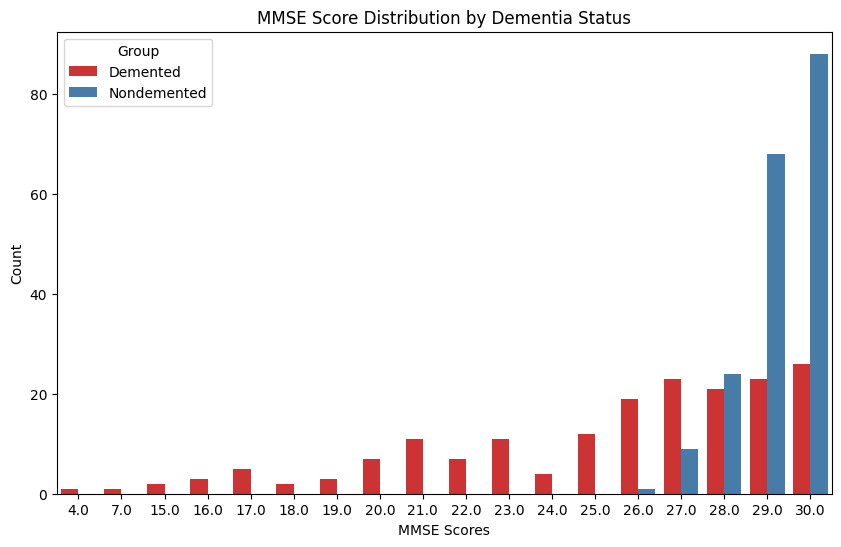

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_copy, x='MMSE', hue='Group', palette='Set1')
plt.title('MMSE Score Distribution by Dementia Status')
plt.xlabel('MMSE Scores')
plt.ylabel('Count')
plt.legend(title='Group', labels = ["Demented", "Nondemented"])
plt.show()

MMSE (Mini Mental State Examination) : Used to assess cognitive function, often used to screen for cognitive impairments; higher is better.
* Nondemented people generally have higher MMSE scores
* Much wider spread for the Demented

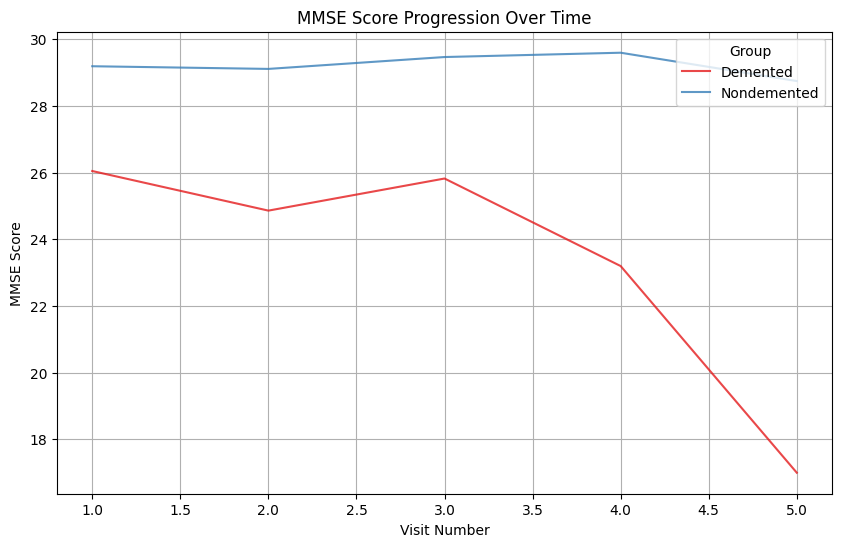

In [ ]:
data_sorted = df_copy[['Subject ID', 'Group', 'Visit', 'MMSE']].sort_values(by=['Subject ID', 'Visit'])

plt.figure(figsize=(10, 6))
sns.lineplot(x='Visit', y='MMSE', hue='Group', data=data_sorted, errorbar=None, alpha=0.8, palette='Set1')
plt.title('MMSE Score Progression Over Time')
plt.xlabel('Visit Number')
plt.ylabel('MMSE Score')
plt.legend(title='Group', loc='upper right', labels = ["Demented", "Nondemented"])
plt.grid(True)
plt.show()

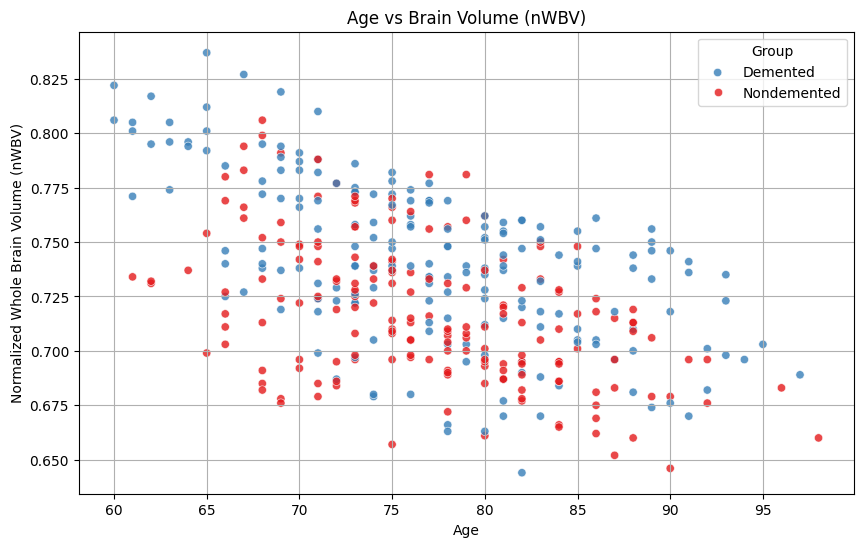

In [ ]:
data_sorted = df_copy[['Age', 'Group', 'nWBV']]

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Age', y='nWBV', hue='Group', data=data_sorted, alpha=0.8, palette='Set1')
plt.title('Age vs Brain Volume (nWBV)')
plt.xlabel('Age')
plt.ylabel('Normalized Whole Brain Volume (nWBV)')
plt.legend(title='Group', loc='upper right', labels = ["Demented", "Nondemented"])
plt.grid(True)
plt.show()

# Data Preprocessing hf with that üëç

In [ ]:
#checking for missing values in the entire dataset
display(df[df.isna().any(axis=1)])

Subject ID  MRI ID  Group  Visit  MR Delay  M/F  Hand  Age  EDUC  SES  \
2             1       2      0      1         0    1     0   75    12  NaN   
3             1       3      0      2       560    1     0   76    12  NaN   
4             1       4      0      3      1895    1     0   80    12  NaN   
10            4      10      0      1         0    1     0   71    16  NaN   
11            4      11      0      3       518    1     0   73    16  NaN   
12            4      12      0      4      1281    1     0   75    16  NaN   
134          52     134      0      1         0    0     0   80    12  NaN   
135          52     135      0      2       490    0     0   81    12  NaN   
207          81     207      0      1         0    0     0   80    12  NaN   
208          81     208      0      2       807    0     0   83    12  NaN   
237          94     237      0      1         0    0     0   76    12  NaN   
238          94     238      0      2       570    0     0   78    12  NaN   
322         130     322      0      1         0    1     0   76    12  NaN   
323         130     323      0      2       552    1     0   78    12  NaN   
356         144     356      0      1         0    0     0   74    12  NaN   
357         144     357      0      2       539    0     0   75    12  NaN   
358         144     358      0      3      1107    0     0   77    12  NaN   
359         145     359      0      1         0    1     0   73    12  NaN   
360         145     360      0      2       776    1     0   75    12  NaN   

     MMSE  CDR  eTIV   nWBV    ASF  
2    23.0  0.5  1678  0.736  1.046  
3    28.0  0.5  1738  0.713  1.010  
4    22.0  0.5  1698  0.701  1.034  
10   28.0  0.5  1357  0.748  1.293  
11   27.0  1.0  1365  0.727  1.286  
12   27.0  1.0  1372  0.710  1.279  
134  30.0  0.5  1430  0.737  1.228  
135  27.0  0.5  1453  0.721  1.208  
207  27.0  0.5  1475  0.762  1.190  
208  23.0  0.5  1484  0.750  1.183  
237  27.0  0.5  1316  0.727  1.333  
238  27.0  1.0  1309  0.709  1.341  
322  27.0  0.5  1557  0.705  1.127  
323  29.0  1.0  1569  0.704  1.119  
356  26.0  0.5  1171  0.733  1.499  
357   NaN  1.0  1169  0.742  1.501  
358   NaN  1.0  1159  0.733  1.515  
359  23.0  0.5  1661  0.698  1.056  
360  20.0  0.5  1654  0.696  1.061

In [15]:
encoder = LabelEncoder()
imputer = SimpleImputer(strategy="median")

df["Group"] = df["Group"].apply(lambda x: 1 if x == 'Nondemented' else 0)
df["Subject ID"] = encoder.fit_transform(df["Subject ID"])
df["MRI ID"] = encoder.fit_transform(df["MRI ID"])
df["M/F"] = encoder.fit_transform(df["M/F"])
df["Hand"] = encoder.fit_transform(df["Hand"])
display(df)

Subject ID  MRI ID  Group  Visit  MR Delay  M/F  Hand  Age  EDUC  SES  \
0             0       0      0      1         0    1     0   87    14  2.0   
1             0       1      0      2       457    1     0   88    14  2.0   
2             1       2      0      1         0    1     0   75    12  NaN   
3             1       3      0      2       560    1     0   76    12  NaN   
4             1       4      0      3      1895    1     0   80    12  NaN   
..          ...     ...    ...    ...       ...  ...   ...  ...   ...  ...   
368         148     368      0      2       842    1     0   82    16  1.0   
369         148     369      0      3      2297    1     0   86    16  1.0   
370         149     370      0      1         0    0     0   61    13  2.0   
371         149     371      0      2       763    0     0   63    13  2.0   
372         149     372      0      3      1608    0     0   65    13  2.0   

     MMSE  CDR  eTIV   nWBV    ASF  
0    27.0  0.0  1987  0.696  0.883  
1    30.0  0.0  2004  0.681  0.876  
2    23.0  0.5  1678  0.736  1.046  
3    28.0  0.5  1738  0.713  1.010  
4    22.0  0.5  1698  0.701  1.034  
..    ...  ...   ...    ...    ...  
368  28.0  0.5  1693  0.694  1.037  
369  26.0  0.5  1688  0.675  1.040  
370  30.0  0.0  1319  0.801  1.331  
371  30.0  0.0  1327  0.796  1.323  
372  30.0  0.0  1333  0.801  1.317  

[373 rows x 15 columns]

In [ ]:
#not using these variables, feel free to mess around and change them idk
df = df.drop(columns=["MRI ID", "Group", "Hand"])
display(df)

Subject ID  Visit  MR Delay M/F  Age  EDUC  SES  MMSE  CDR  eTIV   nWBV  \
0    OAS2_0001      1         0   M   87    14  2.0  27.0  0.0  1987  0.696   
1    OAS2_0001      2       457   M   88    14  2.0  30.0  0.0  2004  0.681   
2    OAS2_0002      1         0   M   75    12  NaN  23.0  0.5  1678  0.736   
3    OAS2_0002      2       560   M   76    12  NaN  28.0  0.5  1738  0.713   
4    OAS2_0002      3      1895   M   80    12  NaN  22.0  0.5  1698  0.701   
..         ...    ...       ...  ..  ...   ...  ...   ...  ...   ...    ...   
368  OAS2_0185      2       842   M   82    16  1.0  28.0  0.5  1693  0.694   
369  OAS2_0185      3      2297   M   86    16  1.0  26.0  0.5  1688  0.675   
370  OAS2_0186      1         0   F   61    13  2.0  30.0  0.0  1319  0.801   
371  OAS2_0186      2       763   F   63    13  2.0  30.0  0.0  1327  0.796   
372  OAS2_0186      3      1608   F   65    13  2.0  30.0  0.0  1333  0.801   

       ASF  
0    0.883  
1    0.876  
2    1.046  
3    1.010  
4    1.034  
..     ...  
368  1.037  
369  1.040  
370  1.331  
371  1.323  
372  1.317  

[373 rows x 12 columns]

In [ ]:
#PLEASE CHANGE ME
#change converted to demented to allow binary classification. we are not doing multi classification.
df.loc[df['Group'] == "Converted"] = "Demented"

KeyError: 'Group'